# **Capstone Project Object Detection Model**
---

## **Import Library**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from PIL import Image
from google.colab import files
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, TimeDistributed, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

## **Data Loading**

In [ ]:
!git clone https://github.com/e-Syarat/Machine-Learning.git

Cloning into 'Machine-Learning'...
remote: Enumerating objects: 9123, done.
remote: Total 9123 (delta 0), reused 0 (delta 0), pack-reused 9123 (from 3)
Receiving objects: 100% (9123/9123), 326.59 MiB | 19.66 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (5677/5677), done.


In [ ]:
# Load anotasi
df = pd.read_csv('/content/Machine-Learning/Dataset/annotations/_annotations.csv')

df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,20201018_121502_017_jpg.rf.c51a14fd608383ad354...,640,640,Q,180,142,484,552
1,1645708643-3140361_jpg.rf.97795898b871f0e5c2cc...,640,640,S,298,233,580,487
2,1645708428-7063668_jpg.rf.d9ffb6f01cce144684ab...,640,640,M,157,316,421,640
3,20201018_121115_024_jpg.rf.c195bc0c72323f8c022...,640,640,K,139,131,429,640
4,1645708710-8815057_jpg.rf.3dbee068ec137afbe985...,640,640,V,112,122,371,612


- **Cek jumlah data dari setiap kelas**

In [ ]:
df['class'].value_counts()

,count
class,
M,222
X,221
S,220
Q,220
V,220
C,220
H,220
Y,220
A,220


In [ ]:
# Melakukan pengecekan apakah file tersebut ada
img_name = df['filename'].iloc[0]
img_path = f'/content/Machine-Learning/Dataset/data/{img_name}'

import os
print("Apakah file ada:", os.path.exists(img_path))

Apakah file ada: True


- **Encode Label dan One-Hot Encoding**

In [ ]:
# Simpan label huruf asli
class_labels = df['class'].copy()

# Encode label
label_encoder = LabelEncoder()
class_encoded = label_encoder.fit_transform(class_labels)

# One-hot encode menggunakan Keras
num_classes = len(label_encoder.classes_)
onehot_labels = to_categorical(class_encoded, num_classes=num_classes)  # shape: (N, num_classes)

- **Normalisasi Bounding Box**

In [ ]:
# Normalisasi bounding box
def normalize_bbox(row):
    width, height = row['width'], row['height']
    x_center = (row['xmin'] + row['xmax']) / 2 / width
    y_center = (row['ymin'] + row['ymax']) / 2 / height
    box_width = (row['xmax'] - row['xmin']) / width
    box_height = (row['ymax'] - row['ymin']) / height
    return [x_center, y_center, box_width, box_height]

# Apply normalisasi
bbox_data = df.apply(normalize_bbox, axis=1, result_type='expand').values  # shape: (N, 4)

# Gabungkan bbox dan label one-hot
targets = np.concatenate([bbox_data, onehot_labels], axis=1)  # shape: (N, 4 + num_classes)

- **Load dan Preprocess Gambar**

In [ ]:
image_dir = "/content/Machine-Learning/Dataset/data"

def load_and_preprocess_image(filename):
    img_path = os.path.join(image_dir, filename)
    if not os.path.exists(img_path):
        print(f"File tidak ditemukan: {img_path}")
        return np.zeros((128, 128, 3))
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    return img_array


images = np.array([load_and_preprocess_image(fname) for fname in df['filename']])

- **Split Dataset: Train / Validation / Test**

In [ ]:
# Split dataset menjadi Train, Valid, Test (70%, 15%, 15%)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    images, targets, test_size=0.15, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42
)

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 3857
Validation size: 965
Test size: 851


- **Augmentasi Data**

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1
)
datagen.fit(X_train)

- **Cek Distribusi Label Kelas**

In [ ]:
# Ambil argmax
labels = np.argmax(y_train[:, 4:], axis=1)

# Hitung frekuensi masing-masing kelas
label_counts = pd.Series(labels).value_counts().sort_index()

# Mapping kembali ke label asli
label_names = label_encoder.classes_
label_counts.index = [label_names[i] for i in label_counts.index]

print(label_counts)

A    136
B    158
C    152
D    157
E    150
F    156
G    148
H    143
I    159
J    125
K    146
L    144
M    158
N    154
O    148
P    155
Q    150
R    150
S    152
T    141
U    163
V    142
W    135
X    151
Y    143
Z    141
Name: count, dtype: int64


---

## **Membangun Model**

In [ ]:
def build_yolo_single_output(input_shape=(128, 128, 3), num_classes=26):
    inputs = Input(shape=input_shape)

    x = Conv2D(16, 3, padding='same', activation='relu')(inputs)
    x = MaxPooling2D()(x)

    x = Conv2D(32, 3, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, 3, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)

    x = Flatten()(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output: gabungan bbox dan class
    bbox_output = Dense(4, activation='sigmoid')(x)
    class_output = Dense(num_classes, activation='softmax')(x)
    combined_output = Concatenate(name='output')( [bbox_output, class_output] )

    model = Model(inputs=inputs, outputs=combined_output)
    return model

# Bangun dan tampilkan model
model = build_yolo_single_output(num_classes=26)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 128) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │    524,352 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      8,320 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4)         │        516 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 26)        │      3,354 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 30)        │          0 │ dense_2[0][0],    │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 633,982 (2.42 MB)

 Trainable params: 633,982 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("Shape output model:", model.output_shape)
print("Shape y_train:", y_train.shape)

Shape output model: (None, 30)
Shape y_train: (3857, 30)


- **Pemisahan Label: Bounding Box dan Class**

In [ ]:
# Misalnya y_train shape-nya (N, 30) → 4 untuk bbox, 26 untuk class one-hot
y_train_bbox = y_train[:, :4]
y_train_class = y_train[:, 4:]

y_val_bbox = y_val[:, :4]
y_val_class = y_val[:, 4:]

In [ ]:
# Gabungkan y_train dan y_val menjadi (N, 30)
y_train_combined = np.concatenate([y_train_bbox, y_train_class], axis=1)
y_val_combined = np.concatenate([y_val_bbox, y_val_class], axis=1)

In [ ]:
def custom_yolo_loss(y_true, y_pred):
    bbox_true = y_true[:, :4]
    bbox_pred = y_pred[:, :4]

    class_true = y_true[:, 4:]
    class_pred = y_pred[:, 4:]

    bbox_loss = tf.reduce_mean(tf.square(bbox_true - bbox_pred))
    class_loss = tf.reduce_mean(
        tf.keras.losses.categorical_crossentropy(class_true, class_pred)
    )

    return bbox_loss + 5.0 * class_loss

In [ ]:
early_stop = EarlyStopping(
    monitor='loss',
    patience=4,
    restore_best_weights=True
)

- **Kompilasi Model**

In [ ]:
model = build_yolo_single_output()
model.compile(
    optimizer='adam',
    loss=custom_yolo_loss,
    metrics=['accuracy']
)

- **Pelatihan Model**

In [ ]:
history = model.fit(
    X_train,
    y_train_combined,
    validation_data=(X_val, y_val_combined),
    epochs=150,
    batch_size=32,
)

Epoch 1/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.0000e+00 - loss: 16.3232 - val_accuracy: 0.0000e+00 - val_loss: 16.3165
Epoch 2/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.0000e+00 - loss: 16.3010 - val_accuracy: 0.0000e+00 - val_loss: 16.3150
Epoch 3/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.0000e+00 - loss: 16.3038 - val_accuracy: 0.0000e+00 - val_loss: 16.3373
Epoch 4/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 9.2859e-04 - loss: 15.9451 - val_accuracy: 0.0187 - val_loss: 14.3724
Epoch 5/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.0119 - loss: 14.3950 - val_accuracy: 0.0062 - val_loss: 12.6163
Epoch 6/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0277 - loss: 13.0289 - val_accuracy: 0.0187 - val_loss: 11.8381
Epoch 7/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.0510 - loss: 11.8316 - val_accuracy: 0.0435 - val_loss: 10.0895
Epoch 8/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13m

---

## Evaluasi Model

- **Plot Training dan Validation Loss**

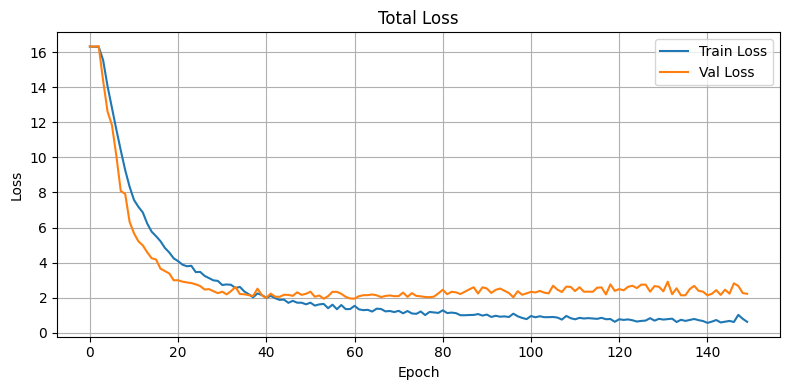

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


- **Plot Training dan Validation Accuracy**

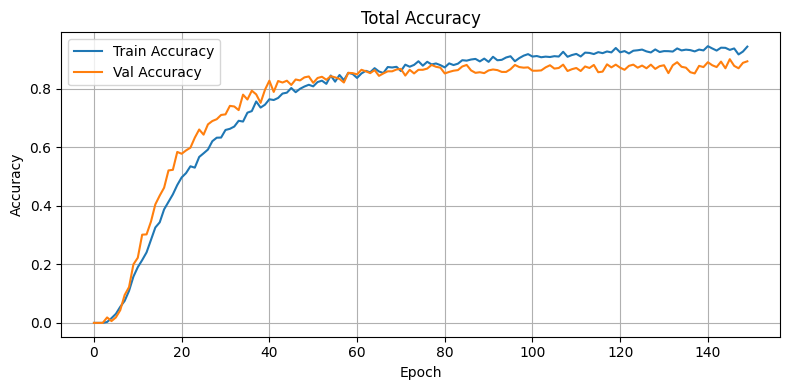

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Total Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


- **Akurasi Model**

In [ ]:
eval_results = model.evaluate(X_val, y_val_combined, verbose=1)
print(f"Validation Loss: {eval_results[0]:.4f}, Classification Accuracy: {eval_results[1]:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9075 - loss: 1.7606
Validation Loss: 2.2280, Classification Accuracy: 0.8943


- **Menghitung Mean IoU (Intersection over Union)**

In [ ]:
def compute_iou(box1, box2):
    x1_min = box1[0] - box1[2]/2
    y1_min = box1[1] - box1[3]/2
    x1_max = box1[0] + box1[2]/2
    y1_max = box1[1] + box1[3]/2

    x2_min = box2[0] - box2[2]/2
    y2_min = box2[1] - box2[3]/2
    x2_max = box2[0] + box2[2]/2
    y2_max = box2[1] + box2[3]/2

    xi1 = max(x1_min, x2_min)
    yi1 = max(y1_min, y2_min)
    xi2 = min(x1_max, x2_max)
    yi2 = min(y1_max, y2_max)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area if union_area != 0 else 0
    return iou

In [ ]:
pred_combined = model.predict(X_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


In [ ]:
bbox_pred = pred_combined[:, :4]
class_pred = pred_combined[:, 4:]

bbox_true = y_test[:, :4]
class_true = y_test[:, 4:]

In [ ]:
ious = [compute_iou(b1, b2) for b1, b2 in zip(bbox_true, bbox_pred)]
print(f"Mean IoU: {np.mean(ious):.4f}")

Mean IoU: 0.5734


- **Visualisasi Bounding Box**

In [ ]:
def plot_prediction(image, pred_bbox, pred_class_probs, true_bbox, true_class_probs, class_names):
    h, w = image.shape[:2]
    pred_class = np.argmax(pred_class_probs)
    true_class = np.argmax(true_class_probs)

    def denorm(box):
        x, y, bw, bh = box
        x1 = int((x - bw/2) * w)
        y1 = int((y - bh/2) * h)
        x2 = int((x + bw/2) * w)
        y2 = int((y + bh/2) * h)
        return x1, y1, x2, y2

    img = (image * 255).astype(np.uint8).copy()

    # Ground truth - green
    x1, y1, x2, y2 = denorm(true_bbox)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Prediction - red
    x1, y1, x2, y2 = denorm(pred_bbox)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

    plt.imshow(img)
    plt.title(f"True: {class_names[true_class]}, Pred: {class_names[pred_class]}")
    plt.axis('off')
    plt.show()

- **Tampilkan 10 Gambar Contoh**

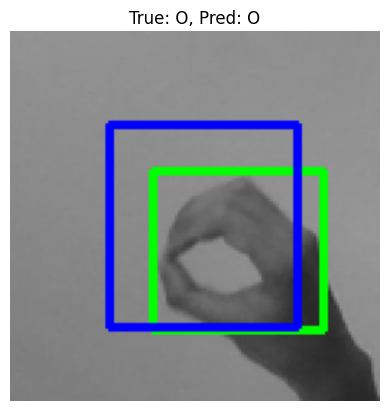

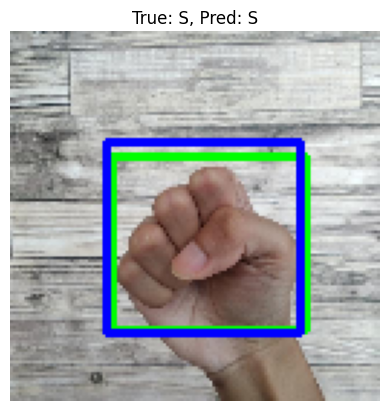

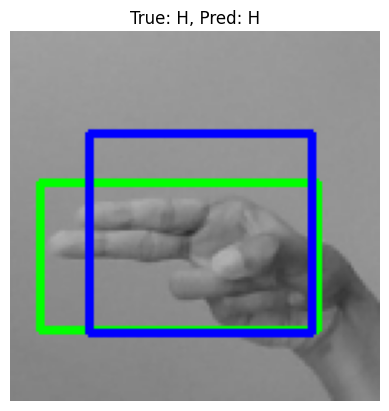

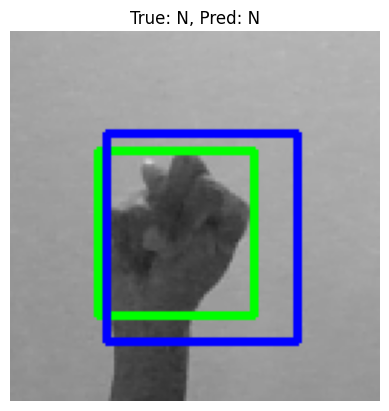

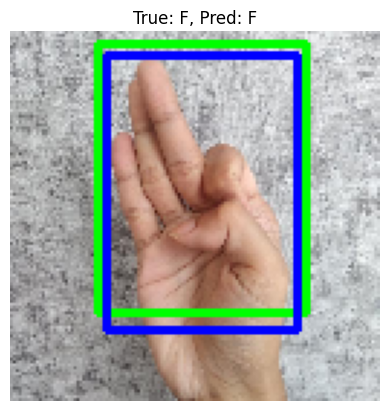

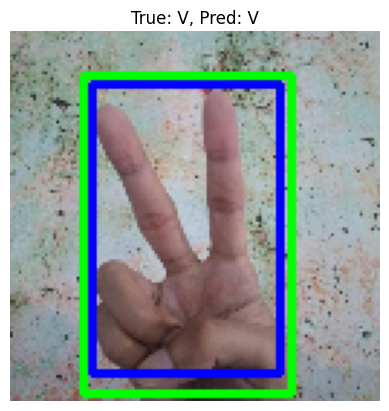

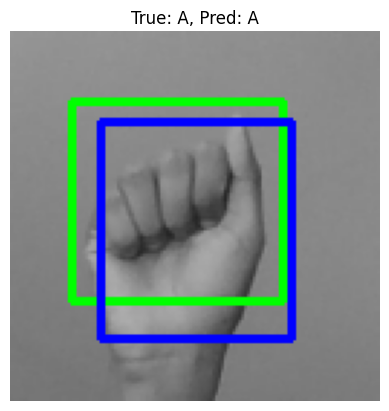

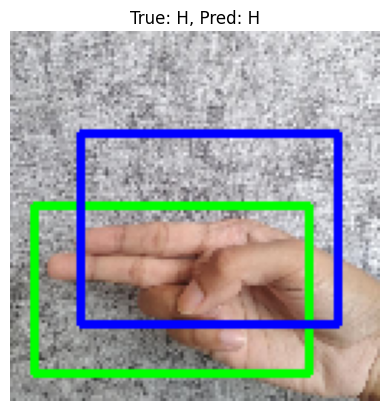

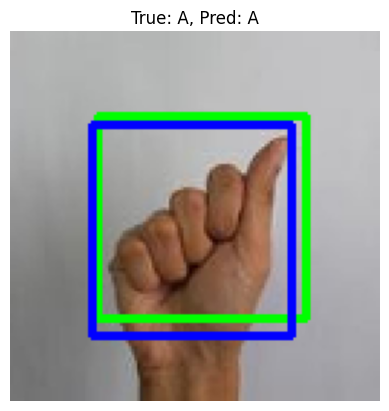

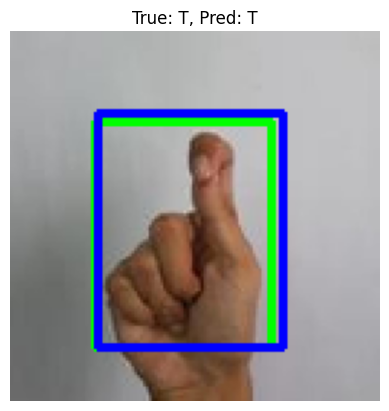

In [ ]:
class_names = label_encoder.classes_

for i in range(10):
    plot_prediction(
        X_test[i],
        bbox_pred[i],
        class_pred[i],
        bbox_true[i],
        class_true[i],
        class_names
    )

## Menyimpan Model

- **Format h5**

In [ ]:
model.save("model.h5")

In [ ]:
tf.saved_model.save(model, 'sample_data/tf_model')

- **Format tfjs**

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model sample_data/tf_model/ sample_data/tfjs_model

2025-06-07 02:58:03.258435: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749265083.278605    4589 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749265083.284587    4589 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-06-07 02:58:15.470275: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1749265095.470480    4589 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

### **Inferensi**

Silakan upload gambar:


Saving images1.jpg to images1.jpg
File uploaded: images1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


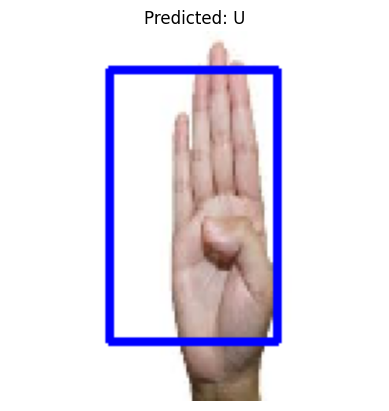

In [ ]:
# Asumsi model dan class_names sudah siap dan ter-load
# model = load_model("model_alphabet.h5", compile=False)
# class_names = label_encoder.classes_

def preprocess_image(img_path):
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # batch dim
    return img_array

def denorm_bbox(box, img_shape=(128, 128)):
    w, h = img_shape
    x, y, bw, bh = box
    x1 = int((x - bw/2) * w)
    y1 = int((y - bh/2) * h)
    x2 = int((x + bw/2) * w)
    y2 = int((y + bh/2) * h)
    return x1, y1, x2, y2

def plot_prediction(image, bbox, class_probs, class_names):
    img = (image * 255).astype(np.uint8).copy()
    x1, y1, x2, y2 = denorm_bbox(bbox, img_shape=img.shape[:2])
    pred_class = np.argmax(class_probs)
    label = class_names[pred_class]

    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    plt.imshow(img)
    plt.title(f"Predicted: {label}")
    plt.axis('off')
    plt.show()

def inference(img_path, model, class_names):
    img_array = preprocess_image(img_path)

    output = model.predict(img_array)
    bbox_pred = output[:, :4]
    class_pred = output[:, 4:]

    plot_prediction(img_array[0], bbox_pred[0], class_pred[0], class_names)


print("Silakan upload gambar:")

uploaded = files.upload()

for filename in uploaded.keys():
    print(f"File uploaded: {filename}")
    inference(filename, model, class_names)

- **Upload model ke google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
